# Routing with OpenCLSim 

This notebook shows how to use the elementary routable core from OpenCLSim. You can also use the more advanced routing functionality from the integration with [opentnsim based routing](32_openclsim_opentnsim_routing.ipynb). In this notebook we show how to use the "move" functionality from OpenCLSim combined with a geometry and a graph to move over a linestring or over a set of nodes.


In [1]:
import datetime
import time
import pickle

import simpy
import numpy as np
import requests
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
import matplotlib.pyplot as plt
import contextily as cx

import openclsim
import openclsim.model

import pyproj

# Earth, to compute spherical distances
WGS84 = pyproj.Geod(ellps="WGS84")


# Example data
Here we want to sail from a location in Rotterdam to Petten along the Ducth coast. We use the [digital twin waterways](https://digitwin-waterways.netlify.app) to create a route. After exporting this route we can use this route to sail both over the geometry and over a graph.  

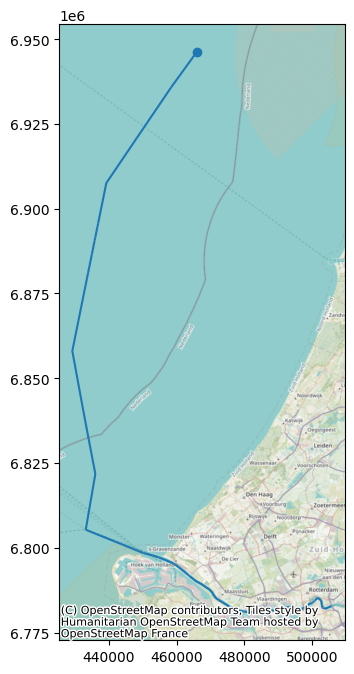

In [2]:
# route created using
# https://digitwin-waterways.netlify.app 
# select two waypoints 
# - van Oord office 
# - sand nourishment location near Petten
# and then export route
route_gdf = gpd.read_file('vanoord-petten.geojson')

# show with a background map
fig, ax = plt.subplots(figsize=(13, 8))
route_gdf.to_crs('EPSG:3857').plot(ax=ax)
cx.add_basemap(ax)


# Route over geometry
In OpenCLSim you can use the routable class to sail over a geometry. For this you need a linestring geometry. Based on the example dataset below we can simplify the geometry column into a simple linestring. 

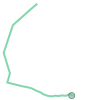

In [3]:
path = shapely.ops.linemerge(
    list(route_gdf[~route_gdf['is_stop']]['geometry'])
)

# get start and end location
location_from_site = shapely.Point(route_gdf.iloc[0].geometry.coords[0])
location_to_site = shapely.Point(route_gdf.iloc[-1].geometry.coords[-1])
shapely.GeometryCollection([path, location_from_site])


## Create a simpy Environment
Create a simpy environment

In [4]:
simulation_start = 0
env = simpy.Environment(initial_time=simulation_start)

## Create sites and create a network

Just create a basic Site with geometry and identifier. 


In [5]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource
    ),
    {},
)


## Create the OpenCLSim sites
OpenCLSim ships always sail between sites. At each site it typically has to do something, like wait for a resource or fill a container. 

In [6]:
# The from site
data_from_site = {
    "env": env,
    "name": "from_site",
    "geometry": location_from_site,
    "capacity": 100,
    "level": 100,
}
# instantiate to_site 
from_site = Site(**data_from_site)

# We only need to define the to_site as an instance for OpenCLSim
data_to_site = {
    "env": env,
    "name": "to_site",
    "geometry": location_to_site,
    "capacity": 100,
    "level": 100,
}
# instantiate to_site 
to_site = Site(**data_to_site)

## Define the vessel
Here we start to integrate OpenCLSim. We make a composed type of `Movable` and the OpenCLSim components that allow to move and transport goods (`HasResource`, `Processor`). 

In [7]:

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        openclsim.core.movable.Routable,
        openclsim.core.movable.Movable,
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.HasResource,
        openclsim.core.HasContainer,
        openclsim.core.Processor,
       
    ),
    {},
)

## Instantiate the vessel
We can now make the vessel. Compared to a normal OpenCLSim route we have the extra `path` property.

In [8]:
# prepare input data for vessel_01
data_vessel01 = {
    "env": env,
    "name": "vessel-01",
    "geometry": location_from_site, 
    "path": path, 
    "capacity": 5,
    "v": 10
}
# instantiate vessel 
vessel = TransportProcessingResource(**data_vessel01)


## Setup the simulation
We can now have all the elements from the simulation. We can setup the regular OpenCLSim housekeeping.

In [9]:
# initialise registry
registry = {}

In [10]:
move_to_activity = openclsim.model.MoveActivity(
    env=env,
    name="Move to activity",
    registry=registry,
    mover=vessel,
    destination=to_site,
)

move_back_activity = openclsim.model.MoveActivity(
    env=env,
    name="Move back activity",
    registry=registry,
    mover=vessel,
    destination=from_site,
)

activity = openclsim.model.SequentialActivity(
    sub_processes=[move_to_activity, move_back_activity], 
    registry=registry, 
    name="Move to and back", 
    env=env
)

In [11]:
# initate the simpy processes defined in the 'move activity' and run simpy
openclsim.model.register_processes([activity])
env.run()

## Show the results
We can now display how long it took:

In [12]:
display(openclsim.plot.get_log_dataframe(activity))

,Activity,Timestamp,ActivityState,type,ref
0,e75f53c3-0d75-46e4-a2d1-fcbde9d04148,1970-01-01 00:00:00.000000,START,NaN,NaN
1,e75f53c3-0d75-46e4-a2d1-fcbde9d04148,1970-01-01 00:00:00.000000,START,subprocess,e9dd0e81-d154-4bc3-89ba-8199014261b6
2,e75f53c3-0d75-46e4-a2d1-fcbde9d04148,1970-01-01 03:55:32.655403,STOP,subprocess,e9dd0e81-d154-4bc3-89ba-8199014261b6
3,e75f53c3-0d75-46e4-a2d1-fcbde9d04148,1970-01-01 03:55:32.655403,START,subprocess,db9ef4b1-0e7b-4f57-bfe1-63a2523fbdab
4,e75f53c3-0d75-46e4-a2d1-fcbde9d04148,1970-01-01 07:51:05.310807,STOP,subprocess,db9ef4b1-0e7b-4f57-bfe1-63a2523fbdab
5,e75f53c3-0d75-46e4-a2d1-fcbde9d04148,1970-01-01 07:51:05.310807,STOP,NaN,NaN


In [13]:
# compute by hand to confirm the duration
distance = WGS84.geometry_length(path)
datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=distance / vessel.v)

datetime.datetime(1970, 1, 1, 3, 58, 50, 885452)

# Routing over a graph
A step further is to sail over a graph. To do this you need to pass extra information. You need a networkx `Graph` consisting of nodes and edges where both edges and nodes contain geospatial information in the form of a `geometry` attribute. 

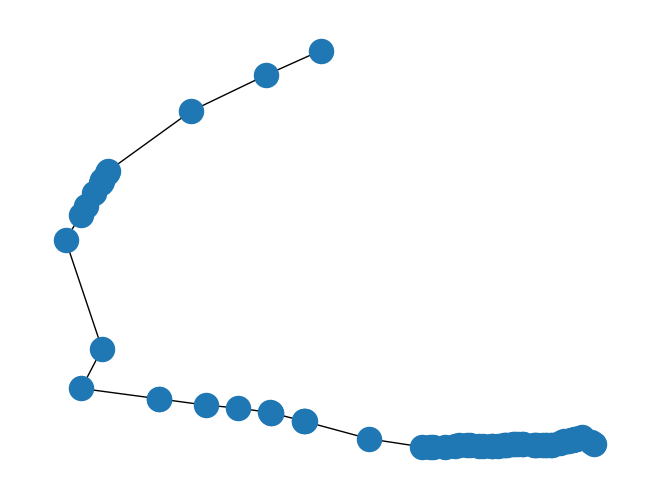

In [14]:
# create a graph and a position map for visualization
pos = {}
graph = nx.Graph()
for i, row in route_gdf.iterrows():
    if row['is_stop']:
        continue
    # route from A to B
    a = row['e'][0]
    b = row['e'][1]
    e = row['e']
    
    # if we have a linestring use the first point
    edge_geometry  = row['geometry']
    # we can extract start and end poiint
    a_geometry = edge_geometry.line_interpolate_point(0) 
    b_geometry = edge_geometry.line_interpolate_point(edge_geometry.length)

    # store visualization parameters
    pos[a] = list(a_geometry.coords)[0]
    pos[b] = list(b_geometry.coords)[0]

    # store edges and nodes
    graph.add_node(a, geometry=a_geometry)
    graph.add_node(b, geometry=b_geometry)
    graph.add_edge(*row['e'], geometry=edge_geometry)
    
nx.draw(graph, pos=pos)

In [15]:
# create a route where we touch all nodes
route = list(route_gdf['e'].apply(lambda x: x[0]))

## Create a simpy Environment
Create a simpy environment. This time we have to add the graph. 

In [16]:
simulation_start = 0
env = simpy.Environment(initial_time=simulation_start)
env.graph = graph

## Create sites and create a network
So far nothing special make sure that you use the `Locatable` class and `Identifiable` so sites have a geometry and for the graph based sailing also have an identifier that can be used to determine the location on the graph.

In [17]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource
    ),
    {},
)


## Create the OpenCLSim sites
OpenCLSim ships always sail between sites. At each site it typically has to do something, like wait for a resource or fill a container. 

In [18]:
# The from site
data_from_site = {
    "env": env,
    "name": "from_site",
    "geometry": location_from_site,
    "capacity": 100,
    "level": 100,
}
# instantiate to_site 
from_site = Site(**data_from_site)

# We only need to define the to_site as an instance for OpenCLSim
data_to_site = {
    "env": env,
    "name": "to_site",
    "geometry": location_to_site,
    "capacity": 100,
    "level": 100,
}
# instantiate to_site 
to_site = Site(**data_to_site)

## Define the vessel
Here we wil use the `Routable` from OpenCLSim.

In [19]:

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        openclsim.core.movable.Routable,
        openclsim.core.movable.Movable,
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.HasResource,
        openclsim.core.HasContainer,
        openclsim.core.Processor,
       
    ),
    {},
)

## Instantiate the vessel
We can now make the vessel. Compared to a normal OpenCLSim route we have the extra `route` property (compared to the `path` property used above).

In [20]:
# prepare input data for vessel_01
data_vessel01 = {
    "env": env,
    "name": "vessel-01",
    "geometry": location_from_site, 
    "capacity": 5,
    "v": 10,
    "route": route
}
# instantiate vessel 
vessel = TransportProcessingResource(**data_vessel01)


## Setup the simulation
We can now have all the elements from the simulation. We can setup the regular OpenCLSim housekeeping.

In [21]:
# initialise registry
registry = {}

In [22]:
move_to_activity = openclsim.model.MoveActivity(
    env=env,
    name="Move to activity",
    registry=registry,
    mover=vessel,
    destination=to_site,
)

move_back_activity = openclsim.model.MoveActivity(
    env=env,
    name="Move back activity",
    registry=registry,
    mover=vessel,
    destination=from_site,
)


In [23]:
activity = openclsim.model.SequentialActivity(
    sub_processes=[move_to_activity, move_back_activity], 
    registry=registry, 
    name="Move to and back", 
    env=env
)

In [24]:
# initate the simpy processes defined in the 'move activity' and run simpy
openclsim.model.register_processes([activity])
env.run()

## Show the results
We can now display how long it took:

In [25]:
display(openclsim.plot.get_log_dataframe(activity))

,Activity,Timestamp,ActivityState,type,ref
0,5353ef4f-b4c8-4781-98e3-226d0950572f,1970-01-01 00:00:00.000000,START,NaN,NaN
1,5353ef4f-b4c8-4781-98e3-226d0950572f,1970-01-01 00:00:00.000000,START,subprocess,2e3629c6-e8b2-4ceb-91a1-fde29d0583a4
2,5353ef4f-b4c8-4781-98e3-226d0950572f,1970-01-01 03:58:50.885452,STOP,subprocess,2e3629c6-e8b2-4ceb-91a1-fde29d0583a4
3,5353ef4f-b4c8-4781-98e3-226d0950572f,1970-01-01 03:58:50.885452,START,subprocess,fd25c031-ddf4-48fd-a993-3851949deb1a
4,5353ef4f-b4c8-4781-98e3-226d0950572f,1970-01-01 07:57:41.770904,STOP,subprocess,fd25c031-ddf4-48fd-a993-3851949deb1a
5,5353ef4f-b4c8-4781-98e3-226d0950572f,1970-01-01 07:57:41.770904,STOP,NaN,NaN


In [26]:
# compute by hand to confirm the duration
distance = WGS84.geometry_length(path)
datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=distance / vessel.v)

datetime.datetime(1970, 1, 1, 3, 58, 50, 885452)